In [1]:
import pandas as pd
import os
import numpy as np
from loguru import logger
import sys
# Load dateloader
from scipy.stats import gaussian_kde
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
import contact_state_classification as csc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
experiment_dir = csc.config.path["experiment_dir"]
cs_classifier = csc.CSClassifier(experiment_dir=experiment_dir, dataset_name=csc.config.path["dataset_name"])

cs_classifier.csd_data_dict.keys()

cs_classifier.csd_data_dict["label"]

cs_classifier.predict(input_data=np.ones([1, 12]))

/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
2021-11-07 17:59:18.034 | INFO     | contact_state_classification.cs_classifier:get_dataset_information:78 - All classes from the dataset RoboticsProject2510 are ['CS']: 


(array([0]), array(['CS'], dtype='<U2'))

In [34]:
cs1_idx_list = [15, 16, 17, 18, 19]
cs3_idx_list = [5, 6, 7, 8, 9]
cs5_idx_list = [10, 11, 12, 13, 14]
cs6_idx_list = [0, 1, 2, 3, 4]

cs1_df = cs_classifier.csd_data_df.loc[cs1_idx_list]["obs_ee_theta"]
cs3_df = cs_classifier.csd_data_df.loc[cs3_idx_list]["obs_ee_theta"]
cs5_df = cs_classifier.csd_data_df.loc[cs5_idx_list]["obs_ee_theta"]
cs6_df = cs_classifier.csd_data_df.loc[cs6_idx_list]["obs_ee_theta"]

# cs1_df_theta = pd.DataFrame([*cs1_df], columns = ['act' + str(x) for x in range(1, 13)])

df_cs1 =  pd.DataFrame({'CS' : [item for item in cs1_idx_list for i in range(12)],
                        'action' : list(range(1, 13)) * len(cs1_idx_list),
                        'obs_theta' : pd.DataFrame([*cs1_df]).to_numpy().flatten()})

df_cs3 =  pd.DataFrame({'CS' : [item for item in cs3_idx_list for i in range(12)],
                        'action' : list(range(1, 13)) * len(cs3_idx_list),
                        'obs_theta' : pd.DataFrame([*cs3_df]).to_numpy().flatten()})

df_cs5 =  pd.DataFrame({'CS' : [item for item in cs5_idx_list for i in range(12)],
                        'action' : list(range(1, 13)) * len(cs5_idx_list),
                        'obs_theta' : pd.DataFrame([*cs5_df]).to_numpy().flatten()})

df_cs6 =  pd.DataFrame({'CS' : [item for item in cs6_idx_list for i in range(12)],
                        'action' : list(range(1, 13)) * len(cs6_idx_list),
                        'obs_theta' : pd.DataFrame([*cs6_df]).to_numpy().flatten()})

In [35]:
# import hiplot as hip
#
# hip.Experiment.from_dataframe(cs1_df_theta).display()

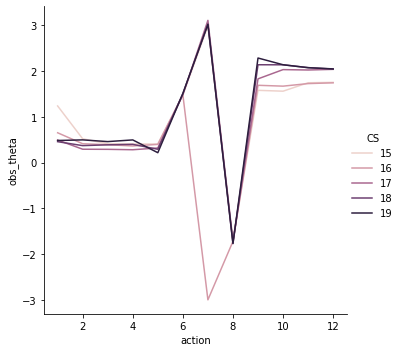

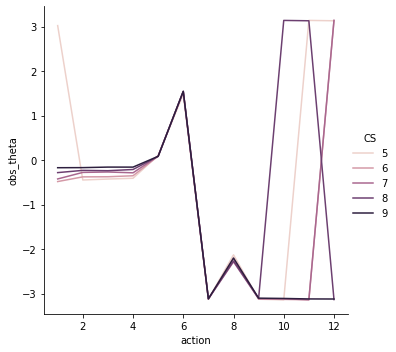

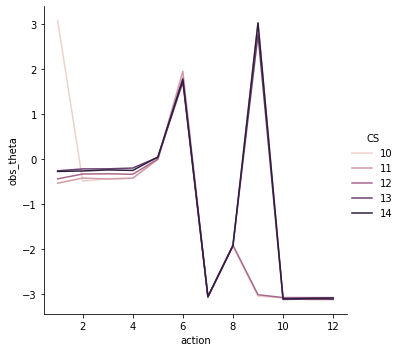

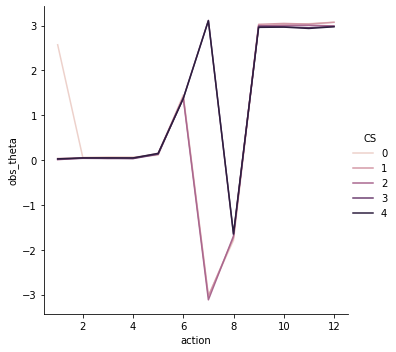

In [36]:
sns.relplot(x="action", y="obs_theta", hue="CS",
            dashes=False, markers=True, kind="line", data=df_cs1)

sns.relplot(x="action", y="obs_theta", hue="CS",
            dashes=False, markers=True, kind="line", data=df_cs3)

sns.relplot(x="action", y="obs_theta", hue="CS",
            dashes=False, markers=True, kind="line", data=df_cs5)

sns.relplot(x="action", y="obs_theta", hue="CS",
            dashes=False, markers=True, kind="line", data=df_cs6)


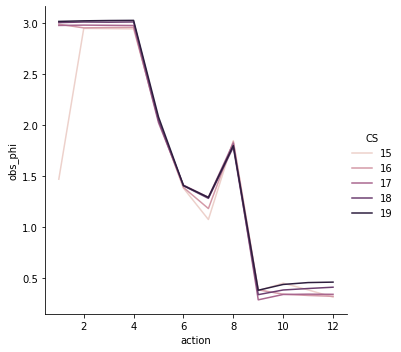

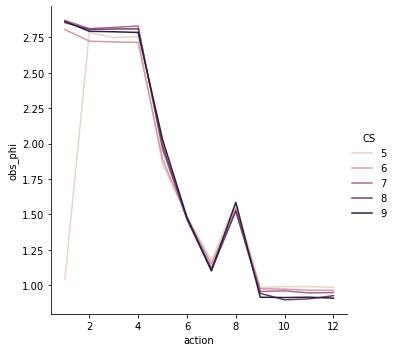

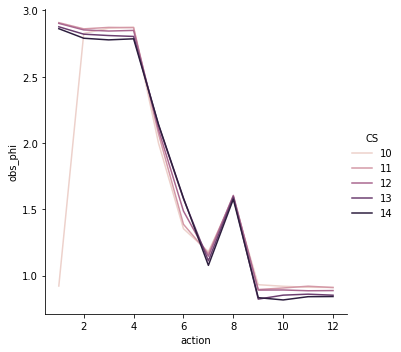

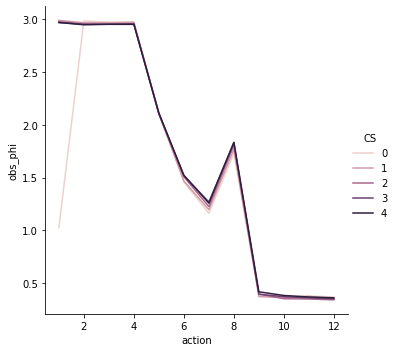

In [37]:
cs1_df = cs_classifier.csd_data_df.loc[cs1_idx_list]["obs_ee_phi"]
cs3_df = cs_classifier.csd_data_df.loc[cs3_idx_list]["obs_ee_phi"]
cs5_df = cs_classifier.csd_data_df.loc[cs5_idx_list]["obs_ee_phi"]
cs6_df = cs_classifier.csd_data_df.loc[cs6_idx_list]["obs_ee_phi"]

df_cs1 =  pd.DataFrame({'CS' : [item for item in cs1_idx_list for i in range(12)],
                        'action' : list(range(1, 13)) * len(cs1_idx_list),
                        'obs_phi' : pd.DataFrame([*cs1_df]).to_numpy().flatten()})

df_cs3 =  pd.DataFrame({'CS' : [item for item in cs3_idx_list for i in range(12)],
                        'action' : list(range(1, 13)) * len(cs3_idx_list),
                        'obs_phi' : pd.DataFrame([*cs3_df]).to_numpy().flatten()})

df_cs5 =  pd.DataFrame({'CS' : [item for item in cs5_idx_list for i in range(12)],
                        'action' : list(range(1, 13)) * len(cs5_idx_list),
                        'obs_phi' : pd.DataFrame([*cs5_df]).to_numpy().flatten()})

df_cs6 =  pd.DataFrame({'CS' : [item for item in cs6_idx_list for i in range(12)],
                        'action' : list(range(1, 13)) * len(cs6_idx_list),
                        'obs_phi' : pd.DataFrame([*cs6_df]).to_numpy().flatten()})

sns.relplot(x="action", y="obs_phi", hue="CS",
            dashes=False, markers=True, kind="line", data=df_cs1)

sns.relplot(x="action", y="obs_phi", hue="CS",
            dashes=False, markers=True, kind="line", data=df_cs3)

sns.relplot(x="action", y="obs_phi", hue="CS",
            dashes=False, markers=True, kind="line", data=df_cs5)

sns.relplot(x="action", y="obs_phi", hue="CS",
            dashes=False, markers=True, kind="line", data=df_cs6)